In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [4]:
%matplotlib inline

In [72]:
import tensorflow as tf
import re
import numpy
import tempfile

import scipy.optimize as sopt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
# From http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

In [7]:
DATAURL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

In [8]:
TMPDIR = tempfile.mkdtemp()

In [9]:
!curl -o $TMPDIR/model.tgz $DATAURL
!tar zxvf $TMPDIR/model.tgz -C $TMPDIR
!ls $TMPDIR

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0  10.2M      0  0:00:08  0:00:08 --:--:-- 11.1M
classify_image_graph_def.pb
cropped_panda.jpg
imagenet_2012_challenge_label_map_proto.pbtxt
imagenet_synset_to_human_label_map.txt
LICENSE
classify_image_graph_def.pb
cropped_panda.jpg
imagenet_2012_challenge_label_map_proto.pbtxt
imagenet_synset_to_human_label_map.txt
LICENSE
model.tgz


In [10]:
synset_to_class = {}
with open(os.path.join(TMPDIR, 'imagenet_synset_to_human_label_map.txt'), 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        synset, name = line.strip().split(None, 1)
        synset_to_class[synset] = name

output_to_class = {}
with open(os.path.join(TMPDIR, 'imagenet_2012_challenge_label_map_proto.pbtxt'), 'r') as f:
    last_target_class = None
    last_target_class_string = None
    for line in f:
        line = line.strip()
        if not line or not line.startswith('target_class'):
            continue
        
        key, val = line.strip().split(None, 1)
        
        if key == "target_class:":
            assert last_target_class is None
            last_target_class = int(val)
        else:
            assert key == "target_class_string:"
            assert val[0] == val[-1] == '"'
            assert last_target_class_string is None
            last_target_class_string = val[1:-1]
        if last_target_class is not None and last_target_class_string is not None:
            output_to_class[last_target_class] = synset_to_class[last_target_class_string]
            last_target_class = None
            last_target_class_string = None


In [11]:
output_to_class

{1: 'kit fox, Vulpes macrotis',
 2: 'English setter',
 3: 'Siberian husky',
 4: 'Australian terrier',
 5: 'English springer, English springer spaniel',
 6: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 7: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 8: 'Egyptian cat',
 9: 'ibex, Capra ibex',
 10: 'Persian cat',
 11: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 12: 'gazelle',
 13: 'porcupine, hedgehog',
 14: 'sea lion',
 15: 'malamute, malemute, Alaskan malamute',
 16: 'badger',
 17: 'Great Dane',
 18: 'Walker hound, Walker foxhound',
 19: 'Welsh springer spaniel',
 20: 'whippet',
 21: 'Scottish deerhound, deerhound',
 22: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 23: 'mink',
 24: 'African elephant, Loxodonta africana',
 25: 'Weimaraner',
 26: 'soft-coated wheaten terrier',
 27: 'Dandie Dinmont, Dandie Dinmont terrier',
 28: 'red wolf, maned wolf, Canis rufus, Canis nig

In [143]:
tf.reset_default_graph()

In [144]:
with open(os.path.join(TMPDIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
    
sess = tf.InteractiveSession()

In [145]:
show_graph()

In [146]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[u'DecodeJpeg/contents',
 u'DecodeJpeg',
 u'Cast',
 u'ExpandDims/dim',
 u'ExpandDims',
 u'ResizeBilinear/size',
 u'ResizeBilinear',
 u'Sub/y',
 u'Sub',
 u'Mul/y',
 u'Mul',
 u'conv/conv2d_params',
 u'conv/Conv2D',
 u'conv/batchnorm/beta',
 u'conv/batchnorm/gamma',
 u'conv/batchnorm/moving_mean',
 u'conv/batchnorm/moving_variance',
 u'conv/batchnorm',
 u'conv/CheckNumerics',
 u'conv/control_dependency',
 u'conv',
 u'conv_1/conv2d_params',
 u'conv_1/Conv2D',
 u'conv_1/batchnorm/beta',
 u'conv_1/batchnorm/gamma',
 u'conv_1/batchnorm/moving_mean',
 u'conv_1/batchnorm/moving_variance',
 u'conv_1/batchnorm',
 u'conv_1/CheckNumerics',
 u'conv_1/control_dependency',
 u'conv_1',
 u'conv_2/conv2d_params',
 u'conv_2/Conv2D',
 u'conv_2/batchnorm/beta',
 u'conv_2/batchnorm/gamma',
 u'conv_2/batchnorm/moving_mean',
 u'conv_2/batchnorm/moving_variance',
 u'conv_2/batchnorm',
 u'conv_2/CheckNumerics',
 u'conv_2/control_dependency',
 u'conv_2',
 u'pool/CheckNumerics',
 u'pool/control_dependency',
 u'poo

In [147]:
unscaled_images = g.get_operation_by_name('Cast').outputs[0]
scaled_images = g.get_operation_by_name('ResizeBilinear').outputs[0]
predictions = g.get_operation_by_name('softmax').outputs[0]


In [148]:
unscaled_images

<tf.Tensor 'Cast:0' shape=(?, ?, 3) dtype=float32>

In [149]:
#!curl -o $TMPDIR/image.jpg http://3.bp.blogspot.com/-VWEXN8U7UAE/UKvunmvcTmI/AAAAAAAABbQ/XWPi-0zb-4c/s320/rock_python1.jpg
!curl -o $TMPDIR/image.jpg https://c1.staticflickr.com/9/8206/8258092492_3db8e65fc7_b.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  672k  100  672k    0     0  1591k      0 --:--:-- --:--:-- --:--:-- 2055k


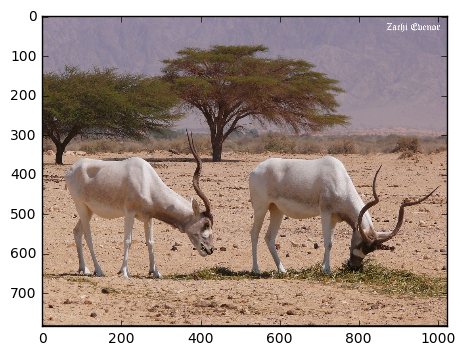

In [150]:
#im = mpimg.imread(os.path.join(TMPDIR, 'cropped_panda.jpg'))
im = mpimg.imread(os.path.join(TMPDIR, 'image.jpg'))
plt.imshow(im)

In [151]:
predictions_v = sess.run(predictions, feed_dict={unscaled_images:im.astype('float32')})

In [152]:
top5 = np.argsort(predictions_v[0])[-5:][::-1]
for pred in top5:
    print ("%s: %f%%" % (output_to_class[pred], predictions_v[0, pred]))

gazelle: 0.772039%
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis: 0.047600%
ram, tup: 0.026461%
ox: 0.025042%
impala, Aepyceros melampus: 0.022469%


# Visualize features

In [397]:
selected_layer = g.get_operation_by_name('mixed/join').outputs[0]
channel = 27
loss = - tf.reduce_sum(selected_layer[:,:,:, channel])

d_loss_d_scaled_images, = tf.gradients(loss, [scaled_images])
img_hist = []
def train_fun(img):
    img = img.reshape(scaled_images.shape.as_list()).astype('float32')
    img_hist.append(np.array(img[0]))
    loss_v, grad_v = sess.run([loss, d_loss_d_scaled_images], feed_dict={scaled_images: img})
    return loss_v, grad_v.ravel().astype('float64')

In [398]:
ret = sopt.fmin_l_bfgs_b(train_fun, np.random.rand(np.prod(scaled_image_v.shape)) + 128.,
                         bounds=[[0,255]]*np.prod(scaled_image_v.shape), iprint=1, maxiter=25)

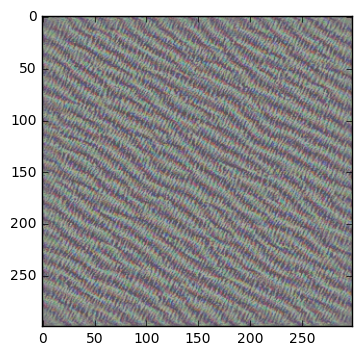

In [399]:
img = img_hist[-1]
plt.imshow((img - img.mean()) / max(img.std(), 1e-4)* 0.1 + 0.5)

# Inceptionism

We will maximize the activations in a layer and see what patterns are picked up by the network.

Please note: a more complicated (and better) notebook is available at https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [400]:
scaled_image_v = sess.run(scaled_images, feed_dict={unscaled_images:im.astype('float32')})

In [401]:
scaled_image_v.shape

(1, 299, 299, 3)

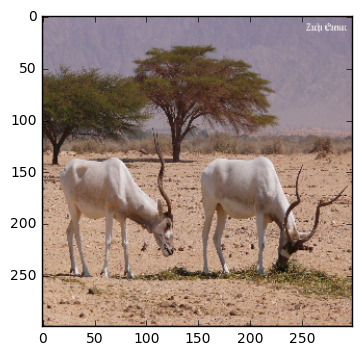

In [402]:
plt.imshow(scaled_image_v[0]/255.0)

In [403]:
#selected_layer = g.get_operation_by_name('mixed_7/join').outputs[0]
#selected_layer = g.get_operation_by_name('conv_3').outputs[0]
selected_layer = g.get_operation_by_name('mixed/tower/conv_1').outputs[0] # closest to inceptionism
#selected_layer = g.get_operation_by_name('mixed_1/tower/conv_1').outputs[0]
#selected_layer = g.get_operation_by_name('mixed_10/tower_1/conv_1').outputs[0]
#loss = - tf.norm(selected_layer)
loss = - tf.reduce_sum(selected_layer)
d_loss_d_scaled_images, = tf.gradients(loss, [scaled_images])
img_hist = []
def train_fun(img):
    img = img.reshape(scaled_images.shape.as_list()).astype('float32')
    img_hist.append(np.array(img[0]))
    loss_v, grad_v = sess.run([loss, d_loss_d_scaled_images], feed_dict={scaled_images: img})
    return loss_v, grad_v.ravel().astype('float64')


In [405]:
ret = sopt.fmin_l_bfgs_b(train_fun, scaled_image_v.ravel().astype('float64'),
                         bounds=[[0,255]]*np.prod(scaled_image_v.shape), iprint=1, maxiter=50)

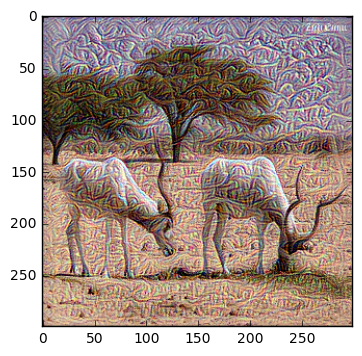

In [408]:
plt.imshow(img_hist[10]/255.)

# Adversarial examples

It turns out one can slightly perturb an input image to dramatically change the network's output

In [409]:
predictions_v[0].argmax()

12

In [410]:
if 0:
    loss = tf.reduce_sum(predictions[:,predictions_v[0].argmax()]) # simply reduce prob of prediction
else:
    logits = g.get_operation_by_name('softmax/logits').outputs[0]
    loss = -tf.reduce_sum(logits[:, 48]) # optimize the weasel class
d_loss_d_scaled_images, = tf.gradients(loss, [scaled_images])
img_hist = []
def train_fun(img):
    img = img.reshape(scaled_images.shape.as_list()).astype('float32')
    img_hist.append(np.array(img[0]))
    loss_v, grad_v = sess.run([loss, d_loss_d_scaled_images], feed_dict={scaled_images: img})
    return loss_v, grad_v.ravel().astype('float64')

In [411]:
ret = sopt.fmin_l_bfgs_b(train_fun, scaled_image_v.ravel().astype('float64'),
                         bounds=[[0,255]]*np.prod(scaled_image_v.shape), iprint=1, maxiter=15)

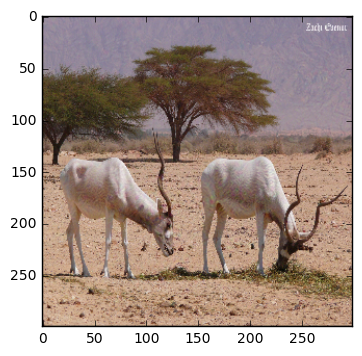

In [412]:
plt.imshow(img_hist[-1]/255.)

weasel: 0.818129%
Italian greyhound: 0.034545%
wallaby, brush kangaroo: 0.032940%
gazelle: 0.032409%
Ibizan hound, Ibizan Podenco: 0.029246%


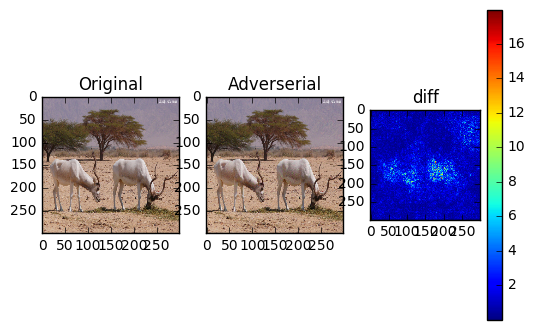

In [413]:
adv_iter=10

predictions_adverserial_v = sess.run(predictions, feed_dict={scaled_images:img_hist[adv_iter][None,...]})
top5 = np.argsort(predictions_adverserial_v[0])[-5:][::-1]
for pred in top5:
    print ("%s: %f%%" % (output_to_class[pred], predictions_adverserial_v[0, pred]))

plt.subplot(131)
plt.imshow(img_hist[0]/255.)
plt.title('Original')

plt.subplot(132)
plt.imshow(img_hist[adv_iter]/255.)
plt.title('Adverserial')

plt.subplot(133)
plt.imshow(np.abs(img_hist[0] - img_hist[adv_iter]).mean(axis=-1))
plt.title('diff')
plt.colorbar()